In [1]:
# default_exp core

In [3]:
#hide
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#hide
!pip install nbdev
from nbdev.showdoc import *

In [2]:
#hide
!pip install nbdev
import os
# define pathway to the weights
weight_filenames = {
    "lcd": "21-2-20-94-universal-lcd.pt",
    "digits":'21-2-25 1k-digits YOLOv5-weights.pt'
    }

resource_folder = "/content/drive/MyDrive/Coding/Roboflow/try it out"

# detectors = []
# for filename in weight_filenames:
# weights_path = os.path.join(resource_folder, weights_filename)



# module name here

> API details.

In [4]:
import os

# safety for re-executions
if not os.path.exists("yolov5"):
  # clone YOLOv5 and reset to a specific git checkpoint that has been verified working
  !git clone https://github.com/ultralytics/yolov5  # clone repo
  !git reset --hard 68211f72c99915a15855f7b99bf5d93f5631330f

# enter the yolov5 directory
%cd yolov5

# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()

if torch.cuda.is_available():
  print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0)))
else:
  raise Exception("You need to enable GPU in this runtime environment")

# return to parent directory
%cd ..

Setup complete. Using torch 1.8.0+cu101 _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16160MB, multi_processor_count=80)
/content


In [5]:
resource_map = {"images": ".jpg", "labels": ".txt"}

In [6]:
import glob

def collect_files(walk_dir):
  res = {}
  for key, extension in resource_map.items():
    resource_generator = glob.iglob(walk_dir + '/**/*' + extension, recursive=True)
    res[key] = [{"pair_id": os.path.basename(x)[:-1*len(extension)], "path": x} for x in resource_generator]
  return res

def matched(res):
  bn = lambda x: set([z["pair_id"] for z in x])
  matched = (bn(res["labels"]).intersection(bn(res["images"])))
  pairs = []
  for resource in matched:
    tmp = {}
    for k in resource_map:
      tmp[k] = [x for x in res[k] if x["pair_id"] == resource][0]
    pairs.append(tmp)
    
  return pairs

In [7]:
default_split_ratio = {
   "train": .7,
   "valid": .2,
   "test": .1 
}

split_ratio = default_split_ratio

In [8]:
import math
files = matched(collect_files("/content/drive/MyDrive/Coding/Roboflow Export (841)"))

train = math.ceil(len(files) * split_ratio["train"])
valid = train + math.ceil(len(files) * split_ratio["valid"])

split =  {"train": files[:train],
"valid": files[train: valid],
"test": files[valid:]}

assert sum([len(split[x]) for x in split]) == len(files)

[{x: len(split[x])} for x in split]

[{'train': 589}, {'valid': 169}, {'test': 83}]

In [29]:
from os.path import join

def mkdir(dir):
  if not os.path.exists(dir):
    !mkdir {dir}


In [42]:
setname = "train"
pairs = split[setname]

dir = join("./", setname)
mkdir(dir)

In [57]:
pair = pairs[2]
for resource, data in pair.items():
  subdir = join(dir, resource)
  mkdir(subdir)
  target = data["path"]
  dest_filename = data["pair_id"]+resource_map[resource]
  destination = join(subdir, dest_filename)
  if not os.path.exists(destination):
    !cp "{target}" "{destination}"
  else:
    print("already exists")

In [54]:
ls train/images

digittake-150-jpg_jpg.rf.abaf9d50852e6d9ab016909ca4f79c50.jpg
digittake-323-jpg_jpg.rf.e7c67a25ed108f594a719603ea28cc70.jpg


In [ ]:

for setname, pairs in split.items():
  dir = join("./", setname)
  mkdir(dir)
  for pair in pairs:
    for resource, data in pair.items():
      subdir = join(dir, resource)
      mkdir(subdir)
      target = data["path"]
      dest_filename = data["pair_id"]+resource_map[resource]
      destination = join(subdir, dest_filename)
      if not os.path.exists(destination):
        !cp "{target}" "{destination}"



In [21]:
lens = {}
for x in split.keys():
  for r in ["images", "labels"]:
    res = !ls "{x}/{r}"
    lens[f"{x}-{r}"] = len(res)
lens

{'test-images': 1,
 'test-labels': 1,
 'train-images': 771,
 'train-labels': 595,
 'valid-images': 107,
 'valid-labels': 1}

In [14]:
import pandas as pd
import json

class ProcessedResult:
  def __init__(self, alias, filename = None, data_in_memory=None):
    if data_in_memory is None:
      with open(filename, "r") as infile:
        data = json.load(infile)
    if filename is None and data is None:
      raise
      
    # instantiate the predictions dataframe
    self.data = data
    self.processed = data["processed"]
    df = pd.DataFrame.from_dict(data["df"])
    
    self.alias = alias
    self.filename = filename

    print( len(self.data),len(self.processed))
    

In [15]:
filename = os.path.join(resource_folder, "additional lcd images/21-3-4 control-camera-light ground truth.json")
a = ProcessedResult(alias="alias", filename = filename)

3 200


In [16]:
index = 121
imgstring = a.data['processed'][index]['base64']

In [17]:
import base64
imgdata = base64.b64decode(imgstring)
filename = 'some_image.jpg'  # I assume you have a way of picking unique filenames
with open(filename, 'wb') as f:
    f.write(imgdata)

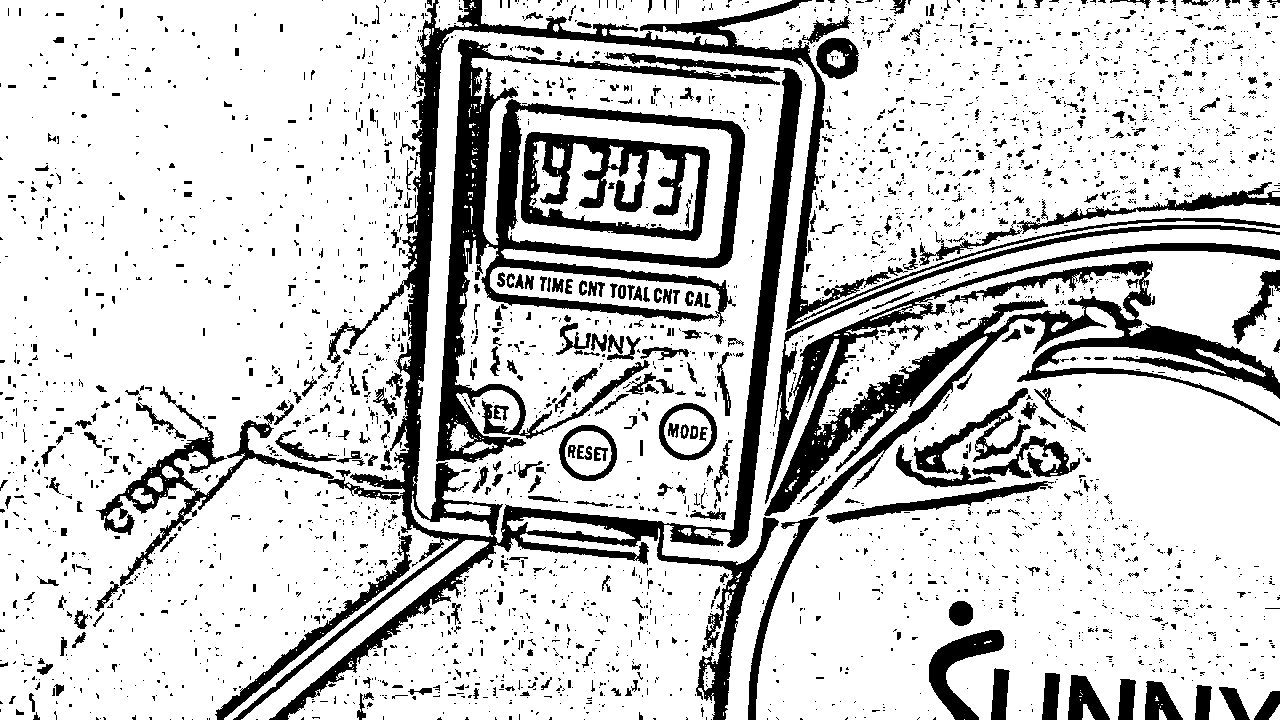

In [47]:
import numpy as np
import cv2 as cv
im = cv.imread('some_image.jpg')
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
# ret, thresh = cv.adaptiveThreshold(imgray, 127, 255, 0)
thresh = cv.adaptiveThreshold(imgray,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 19, 2)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

from google.colab.patches import cv2_imshow
cv2_imshow(thresh)

In [49]:
num_labels, labels_im = cv.connectedComponents(thresh)

In [50]:
num_labels

412

# module name here

> API details.